In [ ]:

!pip install replicate
!pip install pandas
!pip install Pillow
!pip install fuzzywuzzy

In [ ]:
import replicate
import pandas as pd
from PIL import Image
import os
from datetime import datetime, timedelta
from google.colab import files, userdata
from IPython.display import Image as IPImage, display
from fuzzywuzzy import process
import pytz



In [ ]:
wib = pytz.timezone('Asia/Jakarta')

# Set up API token untuk Replicate
try:
    api_token = userdata.get("api_token")
    os.environ["REPLICATE_API_TOKEN"] = api_token
except Exception as e:
    print(f"Error retrieving API token: {str(e)}")
    api_token = None

# Inisialisasi model Granite Vision
model = replicate.Client(api_token=api_token) if api_token else None

In [ ]:
#Fallback vitamin mapping for common foods
vitamin_mapping = {
    "rice": "B1",
    "spinach": "A, C, K",
    "fish": "D, B12",
    "egg": "B12, D",
    "chicken": "B3, B6",
    "broccoli": "C, K, A",
    "potato": "C, B6",
    "tempeh": "B2, B3",
    "tofu": "B1",
    "carrot": "A, K",
    "red kidney beans": "B1, B9",
    "avocado": "E, K, C",
    "banana": "B6, C",
    "red spinach": "A, C",
    "cabbage": "C, K",
    "beef": "B12, B3",
    "milk": "D, B2, B12",
    "cheese": "A, B12",
    "mung beans": "B1, B9",
    "corn": "B1, B5",
    "cassava": "C, B6",
    "sweet potato": "A, C, B6",
    "kangkung": "A, C, K",
    "long beans": "A, C",
    "soybean": "B1, B9",
    "peanut": "E, B3",
    "papaya": "C, A",
    "mango": "C, A, B6",
    "guava": "C, A",
    "tempeh goreng": "B2, B3",
    "tahu goreng": "B1",
    "chicken liver": "A, B12, B2",
    "anchovy": "D, B3",
    "sardine": "D, B12",
    "oatmeal": "B1, B5",
    "green beans": "C, K",
    "jackfruit": "C, A",
    "durian": "C, B1",
    "salted egg": "B12, D",
    "kolplay": "C, K"
}

Upload food image (PNG/JPEG format only):


Saving images.jpg to images (10).jpg

Displaying uploaded image:


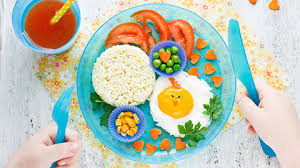


Analyzing image...
Model output: ['', 'The', ' food items in the image include:\n\n1. **R', 'ice**: This is a source of carbohydrates', ', which are a primary source of energy for the body.', " The nutritional content can vary depending on whether it's", ' white or brown rice, but generally, a 1', '/2 cup serving of white rice contains about 1', '10 calories, 2.5 grams of', ' protein, and 1.5 grams of fiber.', '\n\n2. **Egg**: Eggs are a', ' good source of protein, vitamins (including B vit', 'amins and vitamin D), and healthy fats.', ' A large egg (about 2-3 grams) provides', ' about 70 calories, 6.5 grams', ' of protein, and 1.5 grams of fat.', '\n\n3. **Tomatoes**: Tomatoes', ' are rich in vitamin C, potassium, and', ' antio']

Analysis Results:
Detected foods: batang tading, belimbing, beras giling, caisin segar, cengkeh kering, cue selar kuning, daging anak sapi, daging asap, daging domba, daging kambing, daging kerbau, daging kuda, daging sapi, daun cincau, daun melinjo, daun pe

In [ ]:
dataset_path = "/content/nutrition.csv"
try:
    df = pd.read_csv(dataset_path)
    df = df[['name', 'calories', 'proteins']].rename(columns={
        'name': 'Food',
        'calories': 'Calories (kcal)',
        'proteins': 'Protein (g)'
    })
    df['Vitamins'] = df['Food'].str.lower().map(vitamin_mapping).fillna('Unknown')
    nutrition_db = df.set_index('Food')[['Calories (kcal)', 'Protein (g)', 'Vitamins']].to_dict('index')
    nutrition_db = {k.lower(): {'calories': v['Calories (kcal)'], 'protein': v['Protein (g)'], 'vitamins': v['Vitamins']} for k, v in nutrition_db.items()}
except FileNotFoundError:
    print(f"Dataset not found at {dataset_path}. Please ensure nutrition.csv is placed in the correct folder.")
    nutrition_db = {}
except Exception as e:
    print(f"Error loading dataset: {str(e)}")
    nutrition_db = {}

# Fungsi untuk mengunggah dan memvalidasi gambar
def upload_image():
    try:
        print("Upload food image (PNG/JPEG format only):")
        uploaded = files.upload()

        if not uploaded:
            print("No image uploaded. Please try again.")
            return None

        image_path = list(uploaded.keys())[0]

        valid_extensions = ['.png', '.jpg', '.jpeg']
        file_extension = os.path.splitext(image_path)[1].lower()
        if file_extension not in valid_extensions:
            print(f"Invalid file format. Please upload a PNG or JPEG image. Got: {file_extension}")
            return None

        print("\nDisplaying uploaded image:")
        display(IPImage(filename=image_path))

        return image_path
    except Exception as e:
        print(f"Error during image upload: {str(e)}")
        return None

# Fungsi untuk menganalisis gambar makanan
def analyze_food_image(image_path):
    try:
        with open(image_path, "rb") as image_file:
            prompt = (
                "Analyze this food image. Identify the types of food in the image "
                "and provide an estimate of nutritional content (calories, protein, vitamins) for each food type. "
                "Also provide recommendations to improve nutritional value for toddlers."
            )
            output = model.run(
                "ibm-granite/granite-vision-3.2-2b",
                input={
                    "image": image_file,
                    "prompt": prompt,
                    "max_tokens": 200
                }
            )
            return output
    except Exception as e:
        return f"Error in image analysis: {str(e)}"

# Fungsi untuk parsing output model dengan fuzzy matching
def parse_nutrition_output(output):
    identified_foods = []
    recommendations = []

    # Jika output adalah list, gabungkan menjadi string
    if isinstance(output, list):
        output = "\n".join([line for line in output if line.strip()])  # Hanya ambil baris non-kosong
    elif not isinstance(output, str):
        return [], {"calories": 0, "protein": 0, "vitamins": []}, ["Error: Invalid model output format"]

    lines = output.split("\n")
    for line in lines:
        line = line.lower().strip()
        if line:
            # Cari makanan yang cocok dengan database menggunakan fuzzy matching
            for food in nutrition_db.keys():
                if process.extractOne(food, line.split(), score_cutoff=80):
                    identified_foods.append(food)
            if "recommendation" in line:
                recommendations.append(line.replace("recommendation:", "").strip())

    # Hitung total nutrisi
    total_nutrition = {"calories": 0, "protein": 0, "vitamins": []}
    for food in identified_foods:
        if food in nutrition_db:
            total_nutrition["calories"] += nutrition_db[food]["calories"]
            total_nutrition["protein"] += nutrition_db[food]["protein"]
            total_nutrition["vitamins"].append(nutrition_db[food]["vitamins"])

    return identified_foods, total_nutrition, recommendations

# Fungsi untuk membuat grafik batang harian
def create_daily_chart(foods, nutrition_db):
    if not foods:
        return None
    chart_data = {
        "type": "bar",
        "data": {
            "labels": foods,
            "datasets": [
                {
                    "label": "Calories (kcal)",
                    "data": [nutrition_db[food]["calories"] for food in foods],
                    "backgroundColor": "rgba(75, 192, 192, 0.6)",
                    "borderColor": "rgba(75, 192, 192, 1)",
                    "borderWidth": 1
                },
                {
                    "label": "Protein (g)",
                    "data": [nutrition_db[food]["protein"] for food in foods],
                    "backgroundColor": "rgba(255, 99, 132, 0.6)",
                    "borderColor": "rgba(255, 99, 132, 1)",
                    "borderWidth": 1
                }
            ]
        },
        "options": {
            "scales": {
                "y": {
                    "beginAtZero": True,
                    "title": {
                        "display": True,
                        "text": "Amount"
                    }
                },
                "x": {
                    "title": {
                        "display": True,
                        "text": "Foods"
                    }
                }
            },
            "plugins": {
                "title": {
                    "display": True,
                    "text": "Daily Nutrition Analysis"
                }
            }
        }
    }
    return chart_data

# Fungsi untuk membuat grafik garis mingguan
def create_weekly_chart(report_file):
    try:
        df = pd.read_csv(report_file)
        last_week = df[df["Date"] >= (datetime.now(wib) - timedelta(days=7)).strftime("%Y-%m-%d")]
        if last_week.empty:
            return None
        dates = last_week["Date"].tolist()
        calories = last_week["Calories (kcal)"].tolist()
        proteins = last_week["Protein (g)"].tolist()

        chart_data = {
            "type": "line",
            "data": {
                "labels": dates,
                "datasets": [
                    {
                        "label": "Calories (kcal)",
                        "data": calories,
                        "borderColor": "rgba(75, 192, 192, 1)",
                        "fill": False,
                        "tension": 0.4
                    },
                    {
                        "label": "Protein (g)",
                        "data": proteins,
                        "borderColor": "rgba(255, 99, 132, 1)",
                        "fill": False,
                        "tension": 0.4
                    }
                ]
            },
            "options": {
                "scales": {
                    "y": {
                        "beginAtZero": True,
                        "title": {
                            "display": True,
                            "text": "Amount"
                        }
                    },
                    "x": {
                        "title": {
                            "display": True,
                            "text": "Date"
                        }
                    }
                },
                "plugins": {
                    "title": {
                        "display": True,
                        "text": "Weekly Nutrition Trend"
                    }
                }
            }
        }
        return chart_data
    except Exception as e:
        print(f"Error creating weekly chart: {str(e)}")
        return None

# Fungsi untuk menyimpan laporan mingguan
def save_weekly_report(date, foods, nutrition, recommendations):
    report_data = {
        "Date": date,
        "Foods": ", ".join(foods),
        "Calories (kcal)": nutrition["calories"],
        "Protein (g)": nutrition["protein"],
        "Vitamins": ", ".join(nutrition["vitamins"]),
        "Recommendations": "; ".join(recommendations)
    }

    report_file = "weekly_nutrition_report.csv"
    df = pd.DataFrame([report_data])
    if os.path.exists(report_file):
        df_existing = pd.read_csv(report_file)
        df = pd.concat([df_existing, df], ignore_index=True)
    df.to_csv(report_file, index=False)
    return report_file

# Fungsi untuk memeriksa risiko stunting
def check_stunting_risk(report_file):
    try:
        df = pd.read_csv(report_file)
        min_protein = 20
        min_calories = 800

        last_week = df[df["Date"] >= (datetime.now(wib) - timedelta(days=7)).strftime("%Y-%m-%d")]
        avg_protein = last_week["Protein (g)"].mean()
        avg_calories = last_week["Calories (kcal)"].mean()

        risk = []
        if avg_protein < min_protein:
            risk.append("Protein deficiency (average: {:.1f} g, minimum: {} g)".format(avg_protein, min_protein))
        if avg_calories < min_calories:
            risk.append("Calorie deficiency (average: {:.1f} kcal, minimum: {} kcal)".format(avg_calories, min_calories))

        return risk if risk else ["No stunting risk detected based on weekly data."]
    except Exception as e:
        return [f"Error in stunting risk analysis: {str(e)}"]

# Program utama
def main():
    if not nutrition_db:
        print("Cannot proceed without a valid nutrition database. Exiting.")
        return

    image_path = upload_image()
    if not image_path:
        return

    print("\nAnalyzing image...")
    output = analyze_food_image(image_path)
    print("Model output:", output)

    foods, nutrition, recommendations = parse_nutrition_output(output)
    print("\nAnalysis Results:")
    print(f"Detected foods: {', '.join(foods)}")
    print(f"Total Calories: {nutrition['calories']} kcal")
    print(f"Total Protein: {nutrition['protein']} g")
    print(f"Vitamins: {', '.join(nutrition['vitamins'])}")
    print(f"Recommendations: {'; '.join(recommendations)}")

    daily_chart = create_daily_chart(foods, nutrition_db)
    if daily_chart:
        print("\nDaily Nutrition Chart:")
        print("```chartjs")
        print(daily_chart)
        print("```")

    current_date = datetime.now(wib).strftime("%Y-%m-%d")
    report_file = save_weekly_report(current_date, foods, nutrition, recommendations)
    print(f"\nReport saved to: {report_file}")

    weekly_chart = create_weekly_chart(report_file)
    if weekly_chart:
        print("\nWeekly Nutrition Chart:")
        print("```chartjs")
        print(weekly_chart)
        print("```")

    risks = check_stunting_risk(report_file)
    print("\nStunting Risk Analysis:")
    for risk in risks:
        print(f"- {risk}")

if __name__ == "__main__":
    main()